#📌 Extracción

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import requests
import json
from sklearn.preprocessing import StandardScaler

# URL de la API proporcionada
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Cargar los datos desde la API
try:
    response = requests.get(url)
    response.raise_for_status()  # Verificar si hubo errores en la solicitud
    
    # Cargar los datos JSON
    data = response.json()
    
    # Convertir a DataFrame de Pandas
    df = pd.DataFrame(data)
    
    print("Datos cargados exitosamente!")
    print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas")
    print("\nPrimeras filas del DataFrame:")
    print(df.head())
    
except requests.exceptions.RequestException as e:
    print(f"Error al cargar los datos desde la API: {e}")
except json.JSONDecodeError as e:
    print(f"Error al decodificar el JSON: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")

# Si todo salió bien, podemos continuar con el análisis exploratorio
if 'df' in locals():
    # Mostrar información básica del DataFrame
    print("\nInformación del DataFrame:")
    print(df.info())
    
    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    print(df.describe(include='all'))
    
print("\nColumnas disponibles en el DataFrame:")
print(df.columns.tolist())    

Datos cargados exitosamente!
El DataFrame tiene 7267 filas y 6 columnas

Primeras filas del DataFrame:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetSe

#🔧 Transformación

In [60]:
    print("\n=== INSPECCIÓN INICIAL DEL DATASET ===")
    print("Información detallada del DataFrame:")
    print(df.info())

    print("\nTipos de datos por columna:")
    print(df.dtypes)

    print("\n=== ANÁLISIS DE CHURN ===")
    if 'Churn' in df.columns:
        churn_dist = df['Churn'].value_counts(normalize=True)
        print("\nDistribución de Churn (proporciones):")
        print(churn_dist)
        print("\nDistribución de Churn (conteos):")
        print(df['Churn'].value_counts())
    else:
        print("\n¡Error! Columna 'Churn' no encontrada")

    print("\n=== MANEJO DE VALORES FALTANTES ===")
    print("\nValores faltantes por columna:")
    print(df.isnull().sum())

    if 'TotalCharges' in df.columns:
        print("\nConvirtiendo TotalCharges a numérico...")
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].astype(str).str.strip().replace('', np.nan), errors='coerce')
        mask = pd.isna(df['TotalCharges']) & (df.get('tenure', 0) <= 1)
        df.loc[mask, 'TotalCharges'] = df.loc[mask, 'MonthlyCharges']
        print(f"Valores imputados: {mask.sum()}")
    else:
        print("\nAdvertencia: Columna 'TotalCharges' no encontrada")

    print("\n=== TRANSFORMACIÓN DE VARIABLES BINARIAS ===")
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'SeniorCitizen']
    for col in binary_cols:
        if col in df.columns:
            print(f"\nProcesando columna: {col}")
            print("Valores únicos antes:", df[col].unique())
            df[col] = df[col].astype(str).str.strip().str.lower()
            binary_map = {
                'yes': 1, 'y': 1, '1': 1, 'true': 1, 't': 1, 'si': 1, 'sí': 1,
                'no': 0, 'n': 0, '0': 0, 'false': 0, 'f': 0
            }
            df[col] = df[col].map(binary_map)
            if col == 'SeniorCitizen':
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            # Asegurar que no quedan valores NaN antes de convertir a entero
            df[col] = df[col].fillna(0).astype(int)
            print("Valores únicos después:", df[col].unique())
        else:
            print(f"Advertencia: Columna binaria '{col}' no encontrada")

    print("\n=== LIMPIEZA DE COLUMNAS DE SERVICIO ===")
    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
    for col in service_cols:
        if col in df.columns:
            print(f"\nProcesando {col}:")
            print("Valores únicos antes:", df[col].unique())
            df[col] = df[col].replace(['No internet service', 'No phone service'], 'No')
            df[col] = df[col].str.strip().str.lower()
            print("Valores únicos después:", df[col].unique())
        else:
            print(f"Advertencia: Columna de servicio '{col}' no encontrada")

    if 'tenure' in df.columns:
        print("\nProcesando tenure...")
        df['tenure'] = df['tenure'].fillna(0).astype(int)
        print(f"Valores únicos en tenure: {df['tenure'].unique()}")
    else:
        print("\nAdvertencia: Columna 'tenure' no encontrada")

    print("\n=== VERIFICACIÓN POST-LIMPIEZA ===")
    print("\nValores faltantes después de limpieza:")
    print(df.isnull().sum())
    print("\nTipos de datos después de limpieza:")
    print(df.dtypes)

    print("\n=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===")
    categorical_cols = [col for col in ['gender', 'InternetService', 'Contract', 'PaymentMethod'] 
                        if col in df.columns and df[col].dtype == 'object']
    if categorical_cols:
        print(f"Columnas a codificar: {categorical_cols}")
        df_clean = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
        print("\nColumnas creadas:", [c for c in df_clean.columns if c not in df.columns])
    else:
        print("\nAdvertencia: No hay columnas categóricas para codificar")
        df_clean = df.copy()

    print("\n=== ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS ===")
    num_features = [col for col in ['tenure', 'MonthlyCharges', 'TotalCharges'] 
                    if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col])]
    if num_features:
        print(f"Columnas a escalar: {num_features}")
        scaler = StandardScaler()
        df_clean[num_features] = scaler.fit_transform(df_clean[num_features])
        print("\nEstadísticas después de escalar:")
        print(df_clean[num_features].describe().round(2))
    else:
        print("\nAdvertencia: No hay columnas numéricas válidas para escalar")

    print("\n=== CREACIÓN DE COLUMNA 'Cuentas_Diarias' ===")
    if 'MonthlyCharges' in df_clean.columns:
        dias_mes_promedio = 30.42
        df_clean['Cuentas_Diarias'] = df_clean['MonthlyCharges'] / dias_mes_promedio
        print("Columna 'Cuentas_Diarias' creada exitosamente.")
        print(df_clean[['MonthlyCharges', 'Cuentas_Diarias']].head())
    else:
        print("Advertencia: Columna 'MonthlyCharges' no encontrada. No se pudo crear 'Cuentas_Diarias'.")

    print("\n=== EXPORTACIÓN DEL DATASET ===")
    try:
        df_clean.to_csv('telecom_churn_clean.csv', index=False)
        print("\nDataset limpio guardado exitosamente como 'telecom_churn_clean.csv'")
        print(f"- Filas: {df_clean.shape[0]}")
        print(f"- Columnas: {df_clean.shape[1]}")
        if 'Churn' in df_clean.columns:
            print("- Distribución de Churn:")
            print(df_clean['Churn'].value_counts(normalize=True).round(2))
    except Exception as e:
        print(f"\nError al guardar el archivo: {str(e)}")
        print("Recomendación: Verificar permisos de escritura en el directorio actual")




 



=== INSPECCIÓN INICIAL DEL DATASET ===
Información detallada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
None

Tipos de datos por columna:
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object

=== ANÁLISIS DE CHURN ===

Distribución de Churn (proporciones):
Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64

Distribución de Churn (conteos):
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

=== MANEJO DE VALORES FAL

#📊 Carga y análisis

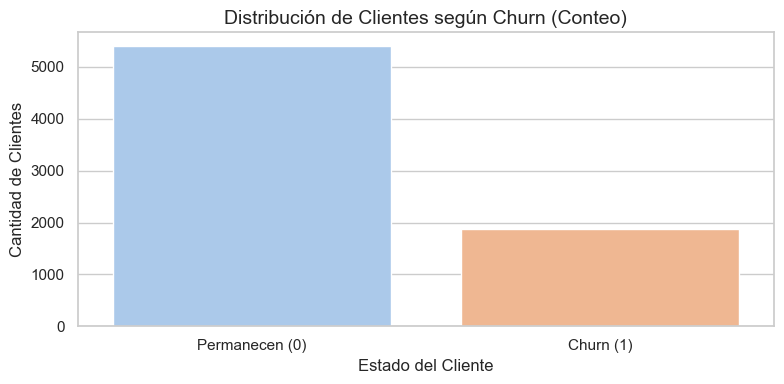

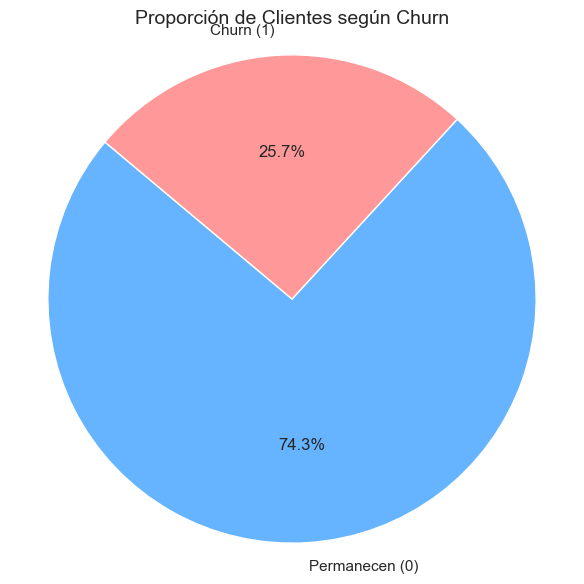

In [61]:
# 1. Distribución general de Churn
plt.figure(figsize=(8, 4))
sns.countplot(x='Churn', data=df_clean, palette='pastel')
plt.title('Distribución de Clientes según Churn (Conteo)', fontsize=14)
plt.xticks([0, 1], ['Permanecen (0)', 'Churn (1)'])
plt.xlabel('Estado del Cliente')
plt.ylabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()

churn_ratio = df_clean['Churn'].value_counts(normalize=True)
plt.figure(figsize=(6, 6))
plt.pie(
    churn_ratio,
    labels=['Permanecen (0)', 'Churn (1)'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Proporción de Clientes según Churn', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 2. Distribución de Churn según variables categóricas
cat_vars = [col for col in ['gender', 'Contract', 'PaymentMethod', 'InternetService'] if col in df.columns]

for col in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn', data=df, palette='Set2')
    plt.title(f'Distribución de Churn según {col}', fontsize=13)
    plt.xlabel(col)
    plt.ylabel('Cantidad de clientes')
    plt.xticks(rotation=45)
    plt.legend(title='Churn', labels=['Permanecen (0)', 'Churn (1)'])
    plt.tight_layout()
    plt.show()
    
    churn_by_group = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    churn_by_group.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='coolwarm')
    plt.title(f'Proporción de Churn por {col}', fontsize=13)
    plt.ylabel('Porcentaje')
    plt.xlabel(col)
    plt.legend(title='Churn', labels=['Permanecen (0)', 'Churn (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Distribución de variables numéricas según Churn
numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']

for col in numeric_vars:
    if col in df_clean.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Churn', y=col, data=df_clean, palette='Set2')
        plt.title(f'Distribución de {col} según Churn', fontsize=13)
        plt.xlabel('Churn (0 = No canceló, 1 = Canceló)')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.kdeplot(data=df_clean[df_clean['Churn'] == 0], x=col, label='Permanecen', shade=True)
        sns.kdeplot(data=df_clean[df_clean['Churn'] == 1], x=col, label='Cancelaron', shade=True)
        plt.title(f'Distribución de {col} por estado de Churn', fontsize=13)
        plt.xlabel(col)
        plt.ylabel('Densidad')
        plt.legend()
        plt.tight_layout()
        plt.show()


#📄Informe final

In [62]:
🔹 Introducción
El presente análisis tiene como objetivo principal estudiar el fenómeno de evasión de clientes (Churn) en una empresa de telecomunicaciones.
La evasión representa un reto importante para el negocio, ya que la pérdida de clientes impacta directamente en los ingresos y la estabilidad
financiera.
Comprender qué factores influyen en la decisión de cancelar el servicio permitirá diseñar estrategias efectivas para reducir el churn y mejorar
la retención.

🔹 Limpieza y Tratamiento de Datos
-Para garantizar la calidad del análisis, se realizaron los siguientes pasos en el procesamiento de los datos:
-Importación del dataset desde una fuente remota en formato JSON.
-Conversión del JSON a un DataFrame de Pandas.
-Manejo de valores faltantes y conversión segura de columnas numéricas (como TotalCharges).
-Normalización y codificación de variables binarias y categóricas.
-Limpieza de categorías inconsistentes en variables de servicio.
-Creación de la variable Cuentas_Diarias, que representa la facturación diaria, para tener una métrica más granular del comportamiento del cliente.
-Estandarización de variables numéricas para facilitar análisis comparativos.

🔹 Análisis Exploratorio de Datos
1. Distribución General de Churn

# Código para mostrar la distribución general de Churn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.countplot(x='Churn', data=df_clean, palette='pastel')
plt.title('Distribución de Clientes según Churn (Conteo)', fontsize=14)
plt.xticks([0, 1], ['Permanecen (0)', 'Churn (1)'])
plt.xlabel('Estado del Cliente')
plt.ylabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()


2. Evasión según Variables Categóricas
Se evaluó cómo la tasa de evasión varía según género, tipo de contrato, método de pago y tipo de servicio de Internet.

cat_vars = [col for col in ['gender', 'Contract', 'PaymentMethod', 'InternetService'] if col in df.columns]

for col in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn', data=df, palette='Set2')
    plt.title(f'Distribución de Churn según {col}', fontsize=13)
    plt.xlabel(col)
    plt.ylabel('Cantidad de clientes')
    plt.xticks(rotation=45)
    plt.legend(title='Churn', labels=['Permanecen (0)', 'Churn (1)'])
    plt.tight_layout()
    plt.show()
3. Distribución de Variables Numéricas según Churn
Se analizaron variables numéricas relevantes, como tiempo de contrato (tenure), facturación mensual (MonthlyCharges), total facturado (TotalCharges) y facturación diaria (Cuentas_Diarias).

numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']

for col in numeric_vars:
    if col in df_clean.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Churn', y=col, data=df_clean, palette='Set2')
        plt.title(f'Distribución de {col} según Churn', fontsize=13)
        plt.xlabel('Churn (0 = No canceló, 1 = Canceló)')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        
        
🔹 Conclusiones e Insights
La tasa de evasión es significativa, con un porcentaje notable de clientes que cancelan el servicio.
Clientes con contratos a corto plazo o mensuales muestran una mayor tendencia a cancelar, lo que sugiere que la estabilidad contractual
es un factor clave.
El método de pago Electronic check y el servicio de Fiber optic están asociados con mayores tasas de churn.
Las variables numéricas indican que los clientes que cancelan suelen tener menor tiempo de permanencia y menor gasto total,
aunque algunos pagan tarifas mensuales elevadas.
La facturación diaria (variable Cuentas_Diarias) es una métrica útil para detectar patrones de comportamiento más finos.

🔹 Recomendaciones
Fomentar contratos a plazo fijo o planes con beneficios por permanencia para reducir la rotación.
Analizar y mejorar la experiencia de clientes que usan Electronic check y Fiber optic.
Implementar estrategias personalizadas para clientes con altos cargos mensuales y poco tiempo en la empresa.
Utilizar la variable Cuentas_Diarias para monitorear comportamientos de riesgo y crear alertas tempranas para acciones de retención.
Continuar el análisis con modelos predictivos para identificar clientes con alta probabilidad de churn y actuar proactivamente.











SyntaxError: invalid character '🔹' (U+1F539) (853869597.py, line 1)